# Statistical study of alternative blocks/chains

Analysis by IsthmusCrypto for the [Monero Archival Project](https://github.com/mitchellpkt/monero_archival_project), a product of *#Noncesense-research-lab*

This notebook investigates various phenomena related to mining of orphaned blocks and side chains. This data was collected by a MAP archival node, running a customized daemon modified by [NeptuneResearch](https://github.com/neptuneresearch).

You can jump to the **Results** section if you want to skip data import and cleaning/engineering.

### Background
See CuriousInventor's 5-minute [non-technical introduction](https://www.youtube.com/watch?v=t5JGQXCTe3c) to Bitcoin, for a review of why forks in the blockchain can occur naturally, and how they are resolved by the concensus mechanism.

We will see several instances of these benign latency-induced forks, along with different side-chain events from different mechanisms.

Monero aims for a 2-minute block time, by adjusting the 'difficulty' for the solutions. Since there is a heavy element of chance involved in mining, some intervals between blocks will be shorter/longer than 2-minutes.

### Conventions
The data in this analysis is already separated into blocks that became the main chain ("block0") and blocks were part of abandoned chains ("block1"). The block0 data is not recorded at heights with an alternate block. (*note to self, check for exceptions*)

The "random" field exists to differentiate each time a copy of a block is received (e.g. multiple times from multiple peers). Being able to distinguish between instances is important for latency studies, but not for the scope of this notebook, so it is dropped and de-duped.

# Preliminaries

## Where are files saved?

In [1]:
block0s_relative_path = 'data_for_analysis/block0s.txt'
block1s_relative_path = 'data_for_analysis/block1s.txt'

## Import libraries

In [2]:
from copy import copy
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Disable auto-scroll

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Import and pre-process data

Two separate pandas DataFrames are used, `b0s` for main chain, and `b1s` for blocks that were abandoned

### Read in from CSV

In [4]:
# Read in the raw data from CSV files
b0s = pd.read_csv(block0s_relative_path)
b1s = pd.read_csv(block1s_relative_path)

# Sort the rows by height
b0s = b0s.sort_values('block_height')
b1s = b1s.sort_values('block_height')


### De-dupe

Because the MAP nodes record *every* instance that a block was received, most heights contain multiple copies from different peers. Each copy is identical, and stamped with a different `block_random`

For the purposes of this analysis/notebook, we only need one copy of each block.

Take a peek for current duplicaties:

In [5]:
display(b1s[0:20])

,block_time,block_height,block_nonce,block_random
0,1522901487,1545098,2684357998,11314
13,1522901487,1545098,2684357998,8118
12,1522901487,1545098,2684357998,7071
11,1522901487,1545098,2684357998,3800
9,1522901487,1545098,2684357998,27796
8,1522901487,1545098,2684357998,27186
7,1522901487,1545098,2684357998,24988
10,1522901487,1545098,2684357998,30751
5,1522901487,1545098,2684357998,17566
4,1522901487,1545098,2684357998,16865


First we remove the `block_random` *column*, so that multiple copies become indistinguishable.

In [6]:
b0s.drop(['block_random'],1,inplace=True)
b1s.drop(['block_random'],1,inplace=True)

Then drop the duplicate *rows*

In [7]:
b0s=b0s.drop_duplicates()
b1s=b1s.drop_duplicates()
b1s[0:20]

,block_time,block_height,block_nonce
0,1522901487,1545098,2684357998
439,1523003051,1546000,570430823
648,1523337099,1547963,2139397
654,1525032170,1562061,3579158795
655,1525032261,1562062,2970728396
660,1525219207,1563626,668103
666,1525470502,1565690,589661
667,1525470534,1565691,358009781
678,1525470959,1565692,2863312291
679,1525472810,1565693,1073825901


# Feature Engineering

Rather than looking at raw block timestamps, we'll want to study derived features like the time between blocks, side chain lengths, etc.

## Generate difference columns

`delta_time` is the timestamp difference between two blocks. `delta_height` marks the difference in height between subsequent rows of the DataFrame, used as an imperfect proxy for identifying breaks between different side chains.

In [8]:
b0s['delta_time'] = b0s['block_time']-b0s['block_time'].shift()
b1s['delta_time'] = b1s['block_time']-b1s['block_time'].shift()

b0s['delta_height'] = b0s['block_height']-b0s['block_height'].shift()
b1s['delta_height'] = b1s['block_height']-b1s['block_height'].shift()

### Drop rows with jumps (delta_height > 1)

This is a crude temporary fix to deal with the fact that the first block in a side chain (or following a gap in `b0s`) will have an anomalous `delta_time` and `delta_height`. The *significant* downside is that this discards the first block of every side chain, and all of the orphaned blocks. 

A better approach would be to turn the rest of the values to NaNs (*to do*)

In [9]:
b0s = b0s[b0s.delta_height == 1]
b1s = b1s[b1s.delta_height == 1]

### What are we left with?

In [10]:
print('Retained ' + str(len(b0s)) + ' main-chain blocks')
print('Retained ' + str(len(b1s)) + ' side-chain blocks')

Retained 17914 main-chain blocks
Retained 190 side-chain blocks


## Label side chains

### Initialize new labels and features:

-  `side_chain_ID` assigns an arbitrary integer to identify each side chain. NOTE: there is a (bad) implicit assumption here alternate blocks at two subsequent heights belong to the same chain. Will be fixed in versions with linked blocks.
-  `side_chain_length` records the length of the side chain (up to this point, not retroactively adjusted)
-  `side_chain_time` records how long a given chain has been growing (based on spoofable miner-reported timestamp)
-  `terminal_block` labels the 'end' block in each side chain. Subject to artifacts from the limitation noted for side_chain_ID.

In [11]:
b1s['side_chain_ID'] = 0
b1s['side_chain_length'] = b1s['block_height']-b1s['block_height'].shift() # how long did this side-chain get?
b1s['side_chain_time'] = 0
b1s['terminal_block']= 0 # is this the last block in the side-chain?

b1s = b1s.reset_index()
b1s.drop(['index','delta_height'], 1, inplace=True)
b1s.side_chain_length[0] = 1 # since we don't know what preceded
b1s.head()

/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,block_time,block_height,block_nonce,delta_time,side_chain_ID,side_chain_length,side_chain_time,terminal_block
0,1525032261,1562062,2970728396,91.0,0,1.0,0,0
1,1525470534,1565691,358009781,32.0,0,3629.0,0,0
2,1525470959,1565692,2863312291,425.0,0,1.0,0,0
3,1525472810,1565693,1073825901,1851.0,0,1.0,0,0
4,1525473108,1565694,20355,298.0,0,1.0,0,0


### Add new info

Calculate accumulated side chain length/time, and label terminal blocks.

Note that initialization of field `side_chain_length` produces some value > 1 for the first block, and = 1 for subsequent blocks. Below, this is converted into actual side chain lengths.

Convention: starting side chains at length 1, appropriate since we dropped the first ones.

In [12]:
side_chain_counter = 0

# Loop over rows = blocks
for index, row in b1s.iterrows():
    
    this_row_val = b1s.side_chain_length[index] # extract current (dummy) label
    
    # If you want extra details:
    # print('index: ' + str(index) + ' this_row_val: ' + str(this_row_val))
    
    # Check whether this is the first block in the chain, or further down
    if this_row_val > 1:
        # first block in the side-chain
        b1s.side_chain_length[index] = 1
        b1s.terminal_block[index-1] = 1 # if this is the first block, the last one was terminal on the previous chain
        side_chain_counter = side_chain_counter + 1 # increment the counter
        b1s.side_chain_ID[index] = side_chain_counter # mark the counter
    else:
        # subsequent block
        if index > 0:
            b1s.side_chain_length[index] = b1s.side_chain_length[index-1]+1
            delta_t_seconds = b1s.block_time[index] - b1s.block_time[index-1]
            b1s.side_chain_time[index] = b1s.side_chain_time[index-1] + delta_t_seconds
            b1s.side_chain_ID[index] = side_chain_counter

/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A

# Results

## General block interval study

Let's take a look at the intervals between blocks, for both the main and side chains. 

What is the *average* interval between blocks? 

In [13]:
b0_mean_time_s = np.mean(b0s.delta_time)
b1_mean_time_s = np.mean(b1s.delta_time)

print('Main-chain blocks come with mean time: ' + str(round(b0_mean_time_s)) + ' seconds = ' + str(round(b0_mean_time_s/60,1)) + ' min')
print('Side-chain blocks come with mean time: ' + str(round(b1_mean_time_s)) + ' seconds = ' + str(round(b1_mean_time_s/60,1)) + ' min')

Main-chain blocks come with mean time: 120 seconds = 2.0 min
Side-chain blocks come with mean time: 6254 seconds = 104.2 min


The main chain blocks are 2 minutes apart, on average. This is what we expect, and is a good validation.

The side chain blocks come at VERY long intervals. The (not-representative) average is almost two hours! 

### Visualize block discovery time

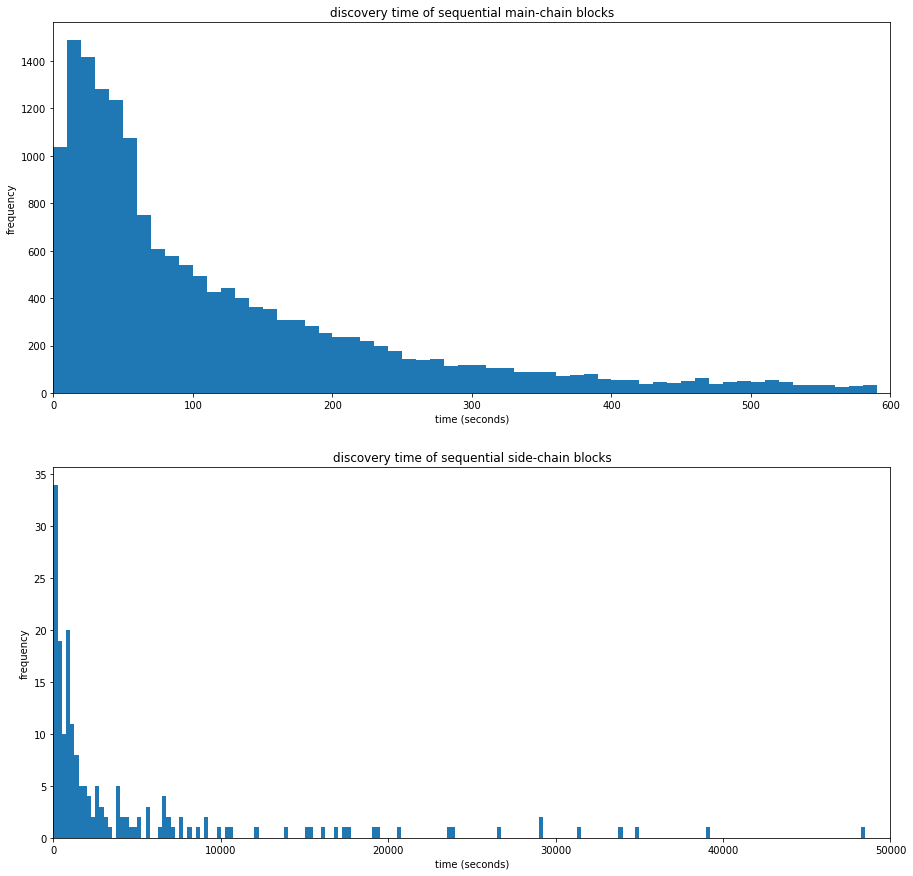

In [14]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('time (seconds)')
ax1.set_ylabel('frequency')
ax1.set_title('discovery time of sequential main-chain blocks')
plt.hist(b0s.delta_time, bins=range(0,600,10))
ax1.set_xlim((0,600))
ax2 = fig.add_subplot(212)
plt.hist(b1s.delta_time, bins=range(0,50000,250))
ax2.set_xlabel('time (seconds)')
ax2.set_ylabel('frequency')
ax2.set_title('discovery time of sequential side-chain blocks')
ax2.set_xlim((0,50000))
pass

**Main chain:**

The top histogram (main chain) shows roughly the distribution that we would expect: long-tailed with a mean of 2 minutes. There seems to be some skew around 60 seconds, which is peculiar. 

Ittay Eyal and Emin Gün Sirer [point out](http://hackingdistributed.com/2014/01/15/detecting-selfish-mining/) that "One could detect [[selfish mining](https://arxiv.org/pdf/1311.0243.pdf)] by looking at the timestamps on successive blocks in the blockchain. Since mining is essentially an independent random process, we'd expect the interblock time gap to be exponentially distributed. Any deviation from this expectation would be suggestive of selfish mining"

**Side chains:**

The side-chain histogram shows mining on an entirely different timescale. Blocks are released very belatedly, often hours behind the preceding height.

Note the x-scale in seconds, and the fact that the majority of side-chain blocks are minutes, hours, or days behind the preceding block. These blocks have NO chance of ever becoming the main chain. Something unusual is happening, and this figure captures multiple phenomena:

-  Most of the natural latency-induced forks would appear in the bin around 120 seconds (2 minutes)

-  Some of the single blocks with extreme times (e.g. ~ 50000 s = 1 month) are probably due to somebody solo mining a block by accident or for fun. 

-  There are many strong chains with blocks on the order of that are too long (e.g. 15 blocks) for the first case, and have too much hashpower for the second case.

## Investigate side chains

Let's look at 24 of peculiar long side chains. The following plots will show how quickly each chain grew.


### How long do these side chains persist?

We expect lots of side chains with length 1 or 2 from natural causes. 

Is anybody out there dumping mining power into longer sidechains? We'll consider 'longer' in terms of height (top plot), and in terms of time (bottom plot)

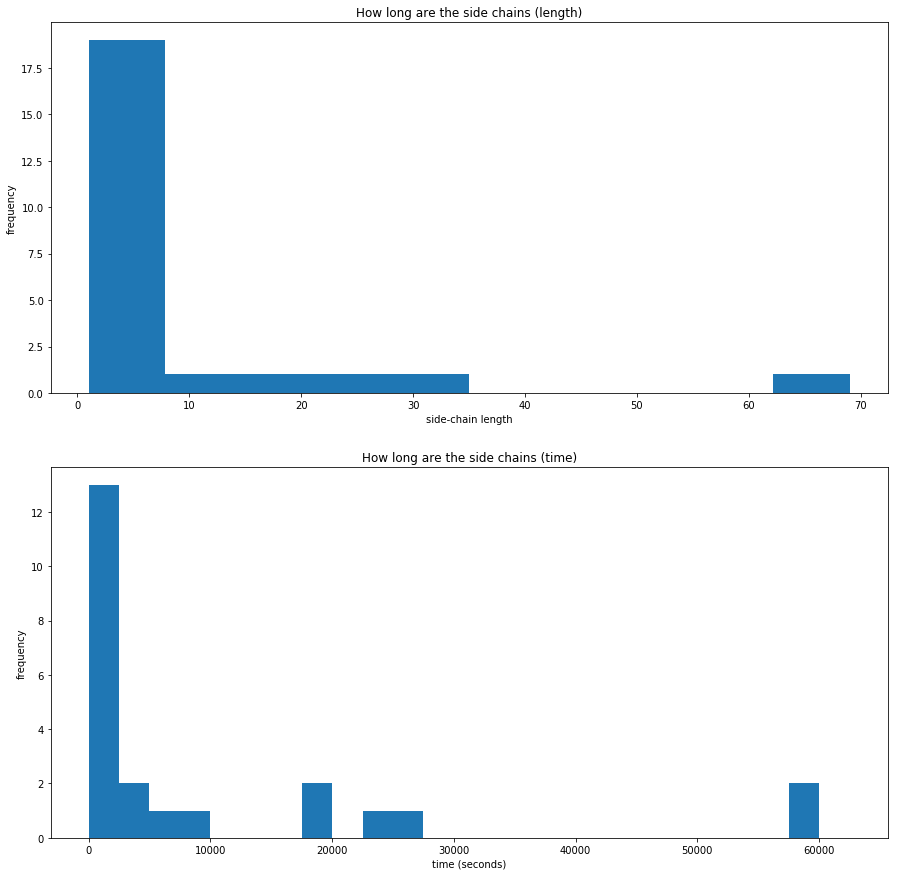

In [15]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('side-chain length')
ax1.set_ylabel('frequency')
ax1.set_title('How long are the side chains (length)')
plt.hist(b1s.side_chain_length[b1s.terminal_block==1])

ax2 = fig.add_subplot(212)
plt.hist(b1s.side_chain_time[b1s.terminal_block==1],bins=range(0,65000,2500))
ax2.set_xlabel('time (seconds)')
ax2.set_ylabel('frequency')
ax2.set_title('How long are the side chains (time)')
pass

Unexpectedly, there are lots of side chains being mined 10, 20, and 30 blocks deep (top plot).

Some of these futile side chains are mined for weeks (bottom plot)

Highly unnatural...

## A closer look at the growth of side chains

It is time to individually inspect different side chains, and see how fast they were produced. The plots below fingerprint the growth of each side chain.

Each chain is colored/numbered differently. Each point shows a single block: the x-axis position indicates how long side chain has grown, and the y-axis position indicates the *cumulative* time that has gone into mining that particular side chain (calculated as the difference between the timestamp on this block and its first block).

The speed with which a given entity can produce blocks for their sidechain is proportional to their hash power. This can be used to identify distinct signatures of different phenomena or entities! Two different long side chains that were mined on the same equipment will show up together on these plots, assuming that their hashrate hasn't changed between runs.

The red line shows 2-minutes per block, so any entity producing blocks near that speed can feasibly overtake (and become) the main chain. The further a side chain is from the red line, the more astronomically improbable this becomes.

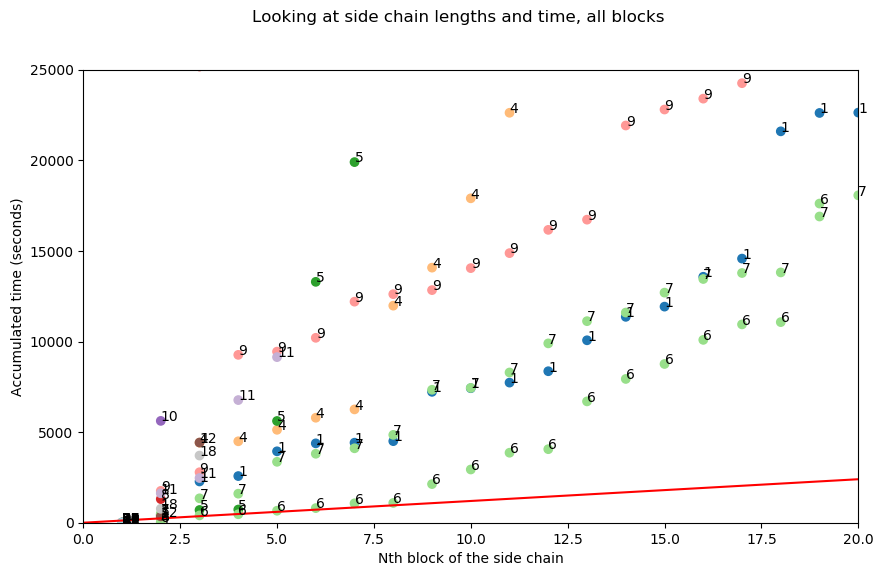

In [16]:
# Let's take a look at the first 20 blocks:
max_chain_length = 20
max_chain_time = 25000

norm_block_time = 120 # seconds

fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(b1s.side_chain_length, b1s.side_chain_time+1, c=b1s.side_chain_ID, cmap='tab20')
fig.suptitle('Looking at side chain lengths and time, all blocks')
plt.xlabel('Nth block of the side chain')
plt.ylabel('Accumulated time (seconds)')
plt.xlim((0,max_chain_length))
plt.ylim((0,max_chain_time))

for i, txt in enumerate(b1s.side_chain_ID):
    # print(i)
    X = b1s.side_chain_length[i]
    Y = b1s.side_chain_time[i]
    S = b1s.side_chain_ID[i]
    # print("X = " + str(X), " // Y = " + str(Y) + " // S = " + str(S))
    if i > 0 and X <= max_chain_length and Y <= max_chain_time:
        plt.text(X,Y,S)
        
# Add on a regular rate
plt.plot((0,max_chain_length), (0, max_chain_length*norm_block_time), c='red')
pass

**Wow** there are several interesting things to note:

Several of the side chains, separated by weeks, show the exact same signature in hashrate (e.g. #1 and #7) and presumably were produced by the same equipment

Side chain #6 produced the first 8 blocks at approximately 2 minutes per block! This could indicate two things:
-  A side chain came within a razor's edge of overtaking the main chain
-  A side chain DID overtake the main chain (!!!) so the original version is marked as "alternate" here

Something seems to cause the chains to lose steam about 7 or 8 blocks in. This could be a coincidence from looking at a small number of examples, but seems prominent in #1, #4, #6, #7. Equipment overheating??

Who could have that much hash power? And these are all since July after we were supposedly rid of ASICs.

Absurdly, one of the side chains was 70 blocks long, with an average of a four hour block discovery time. 
-  To reliably mine at ~ 4 hr/block the entity must have around 1% of total network hashrate!
-  This single side chain would have used around 40,000 EUR worth of energy! 

That is not something that an unlucky amateur miner would accidentally overlook. Here's a zoomed-out version of the above plot:

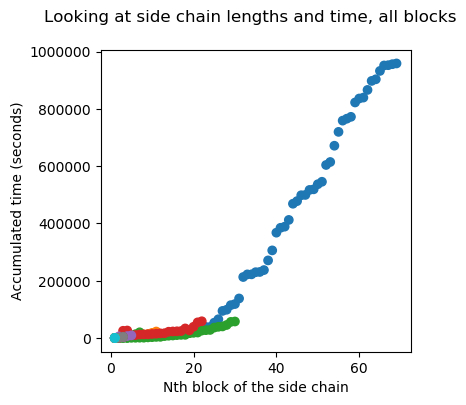

In [17]:
fig = plt.figure(figsize=(4,4), dpi=100)
plt.scatter(b1s.side_chain_length, b1s.side_chain_time+1, c=b1s.side_chain_ID, cmap='tab10')
fig.suptitle('Looking at side chain lengths and time, all blocks')
plt.xlabel('Nth block of the side chain')
plt.ylabel('Accumulated time (seconds)')
plt.axis('tight')
pass

## Summarization of the side chains

Quickly spitting out some text data so I can cross-reference these side chains against mining timing on the main chain.

In [18]:
for i, x in enumerate(b1s.side_chain_ID.unique()):
    #print('Side chain #' + str(i) + ' median time: ', + np.median(b1s.block_time[b1s.side_chain_ID==i]))
    print('Side chain #' + str(i) + ' median time: ' + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(np.median(b1s.block_time[b1s.side_chain_ID==i]))))
    print('\t... started at height ' + str(min(b1s.block_height[b1s.side_chain_ID==i])) + '\n')

Side chain #0 median time: 2018-04-29 15:04:21
	... started at height 1562062

Side chain #1 median time: 2018-05-07 08:38:58
	... started at height 1565691

Side chain #2 median time: 2018-05-05 20:01:52
	... started at height 1566501

Side chain #3 median time: 2018-05-06 10:09:31
	... started at height 1566909

Side chain #4 median time: 2018-05-08 18:28:32
	... started at height 1568537

Side chain #5 median time: 2018-05-17 01:15:15
	... started at height 1574527

Side chain #6 median time: 2018-05-23 03:01:54
	... started at height 1578848

Side chain #7 median time: 2018-05-25 03:19:34
	... started at height 1580197

Side chain #8 median time: 2018-05-27 11:06:31
	... started at height 1581882

Side chain #9 median time: 2018-05-29 09:40:02
	... started at height 1583267

Side chain #10 median time: 2018-05-30 22:37:53
	... started at height 1584465

Side chain #11 median time: 2018-06-03 21:17:59
	... started at height 1587294

Side chain #12 median time: 2018-06-07 11:28:04
	.

# Work in progress. Check back later for more excitement!